# Optional data up and download


In [ ]:
!gdown 1RbfFwYcLTubFLBYWcWW0vGGAUFlqttAF
!unzip P03_6000_train.zip -d P03_6000_train

In [ ]:
!unzip P03_6000_train.zip -d P03_6000_train

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 10017731881595973191
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 49125457920
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 6185398833456495583
 physical_device_desc: "device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:00:10.0, compute capability: 8.6"
 xla_global_id: 416903419]

# Preprocess

In [ ]:
import numpy as np
import imageio
import cv2
import pandas as pd
import random

In [ ]:
black_df = pd.read_csv('/content/black_images.csv', header=None)
black_df.columns = ['image_id']
black_df

image_id
0          image_id
1    502000_6584000
2    587000_6503000
3    573000_6610000
4    389000_6448000
..              ...
648  637000_6502000
649  471000_6487000
650  592000_6601000
651  570000_6610000
652  560000_6601000

[653 rows x 1 columns]

In [ ]:
size = 63

In [ ]:
import numpy as np
import imageio
import cv2
import pandas as pd
import random

batch_size = 500000
X_train = np.empty((batch_size,size,size,3), int)
y_train = np.empty((batch_size), int)

random.seed(69)

train_csv = np.loadtxt("train_cleaned.csv",
                 delimiter=",", dtype=str)

try:
  with open("ristmikud.csv") as f:
    index = 0
    for n, line in enumerate(f):
      if n%1000 == 0:
        print(n)
      pic, *cord = line.split(", ")
      if pic in train_csv:
        gif = imageio.mimread("P03_6000_train/train_orto/orto_%s.gif"%pic)
        gif = np.flip(cv2.cvtColor(gif[0], cv2.COLOR_RGB2BGR), axis=0) #flip y axis because original y origin is below

        # INTERSECTION IMAGES - TRUE
        cords = []
        for i in cord:
          x, y = list(map(int, i.split("-")))
          cords.append((x,y))
          subimage = gif[y-size//2:y+size//2+1, x-size//2:x+size//2+1]
          if subimage.shape[0] == size and subimage.shape[1] == size:
            X_train[index] = subimage
            y_train[index] = 1
            index += 1

        non_intersects = 50

        # NON INTERSECTION IMAGES - FALSE
        for x1,y1 in zip(random.sample(range(1000), non_intersects), random.sample(range(1000), non_intersects)):
          for x2,y2 in cords:
            if ((x1-x2)**2+(y1-y2)**2)**0.5 <= size//2:
              break
          else:
            subimage = gif[y1-size//2:y1+size//2+1, x1-size//2:x1+size//2+1]
            if subimage.shape[0] == size and subimage.shape[1] == size:
              X_train[index] = subimage
              y_train[index] = 0
              index += 1

except IndexError:
  print("still intersections to store")

X_train = np.delete(X_train,np.s_[index:],axis=0)
y_train = np.delete(y_train,np.s_[index:],axis=0)

# Training length
print("ristmike arv:", index, len(X_train), len(y_train))

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
ristmike arv: 205766 205766 205766


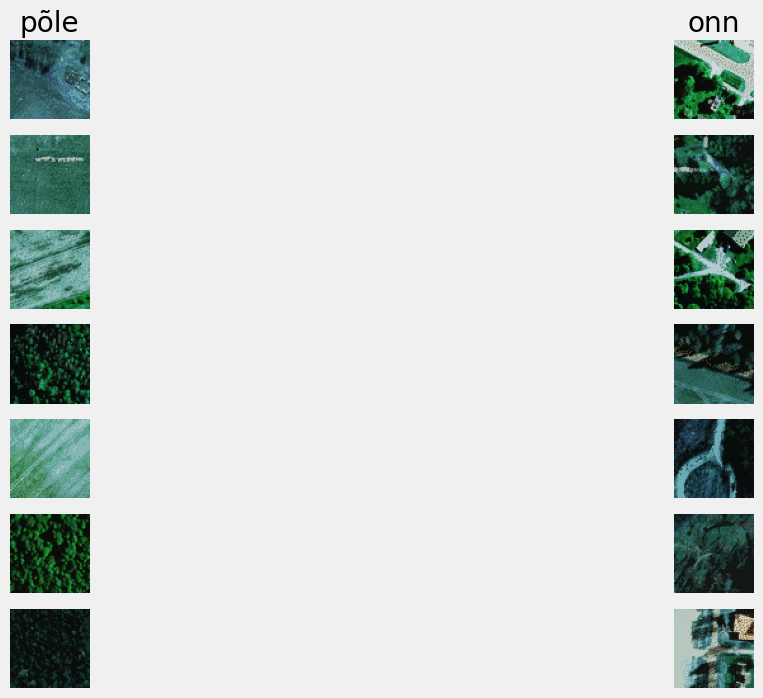

0 169246 1 36520 ratio 0.2157805797478227


In [ ]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (14.0, 8.0) # set default size of plots
# "Names" of classes:
# põle - no intersection 0
# onn - yes intersection 1
class_names = ["põle", "onn"]
num_classes = len(class_names)

samples_per_class = 7 # Number of images from each class we want to see
for y, cls in enumerate(class_names):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].reshape((size, size, 3)), plt.get_cmap('gray'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

zeros = np.sum(y_train==0)
ones = np.sum(y_train==1)
print("0", zeros, "1", ones, "ratio", ones/zeros)

# Matsin learn (Machine learning)

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, Activation, Flatten, Dense, MaxPooling2D, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

x = Input(shape=(size, size, 3))
c1 = Conv2D(size, (3, 3), strides=(1, 1), padding="same")(x)
b1 = BatchNormalization()(c1)
a1 = Activation('relu')(b1)
c2 = Conv2D(size, (3, 3), strides=(1, 1), padding="valid")(a1)
b2 = BatchNormalization()(c2)
a2 = Activation('relu')(b2)
p2 = MaxPooling2D(pool_size=2)(a2)
d2 = Dropout(rate=0.25)(p2)
f2 = Flatten()(d2) # tensor into vector

h3 = Dense(100)(f2)
b3 = BatchNormalization()(h3)
a3 = Activation('relu')(b3)
d3 = Dropout(rate=0.5)(a3)

z = Dense(2)(d3)
p = Activation('softmax')(z)

model = Model(inputs=x, outputs=p)
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])
model.summary()

history = model.fit(X_train, y_train, batch_size=32, epochs=10, validation_split=0.1)



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 63, 63, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 63, 63, 63)        1764      
                                                                 
 batch_normalization (Batch  (None, 63, 63, 63)        252       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 63, 63, 63)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 63)        35784     
                                                                 
 batch_normalization_1 (Bat  (None, 61, 61, 63)        252       
 chNormalization)                                            

# Save or load existing model

In [ ]:
model.save('cnn2.keras') # Muuta nimi, et üle ei kirjutaks

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('cnn2.keras')

# Prediction testing

In [ ]:
import imageio
import cv2
import numpy as np

#test_gif = imageio.mimread("P03_6000_train/train_orto/orto_407000_6471000.gif")
#test_gif = imageio.mimread("P03_6000_train/train_orto/orto_380000_6464000.gif")
#test_gif = imageio.mimread("P03_6000_train/train_orto/orto_538000_6582000.gif")
#test_gif = imageio.mimread("P03_6000_train/train_orto/orto_411000_6458000.gif")
#test_gif = imageio.mimread("P03_6000_train/train_orto/orto_550000_6579000.gif")

import os, random
a = "orto_667000_6567000.gif"#random.choice(os.listdir("/content/P03_1000_test/test_orto/")) #change dir name to whatever

test_gif = imageio.mimread(f"/content/P03_1000_test/test_orto/{a}")

test_gif = np.flip(cv2.cvtColor(test_gif[0], cv2.COLOR_RGB2BGR), axis=0) #flip y axis because original y origin is below

cords = [(x, y) for y in range(size, 1000-size, 5) for x in range(size,1000-size,5)]
grid = np.zeros((len(cords),size,size,3), int)
index = 0
for x, y in cords:
  subimage = test_gif[y-size//2:y+size//2+1, x-size//2:x+size//2+1]
  if subimage.shape[0] == size and subimage.shape[1] == size:
    grid[index] = subimage #np.concatenate((grid, [subimage]))
    index += 1

prediction = model.predict(grid)

958/958 [==============================] - 2s 2ms/step


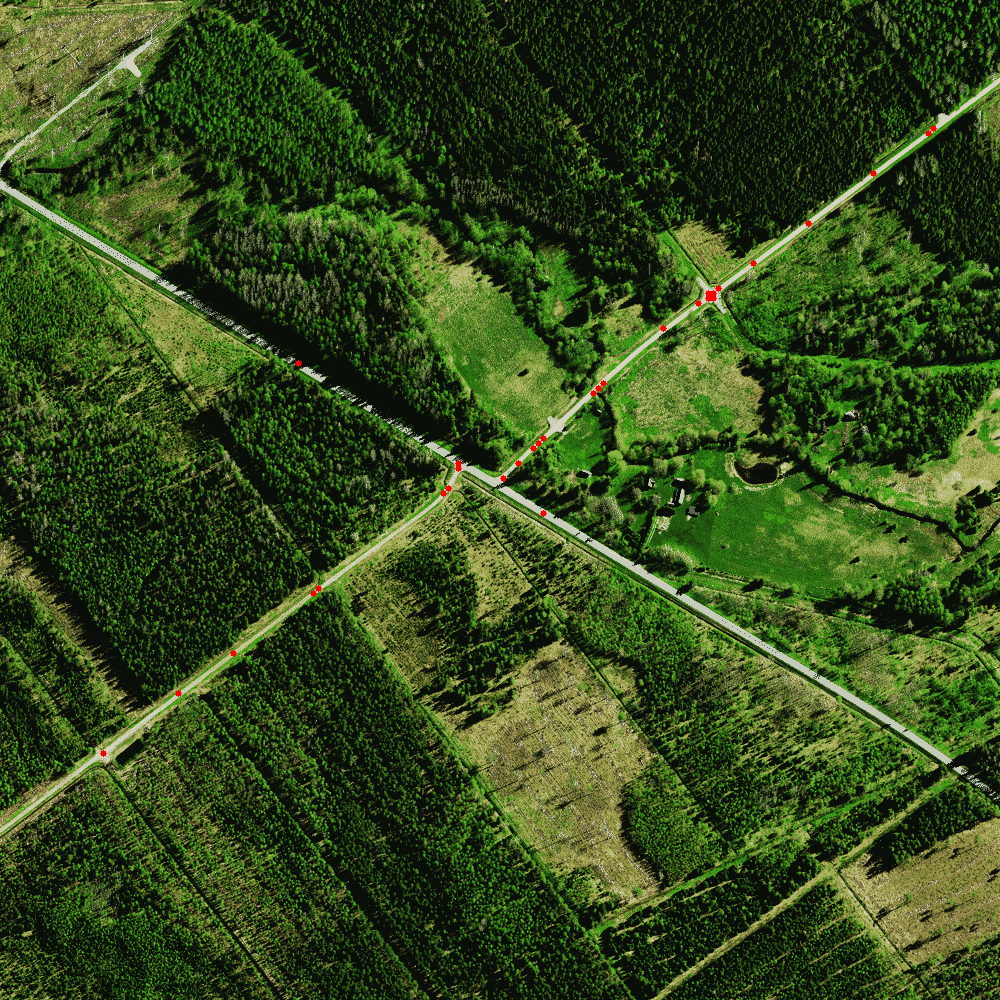

In [ ]:
from google.colab.patches import cv2_imshow

img = test_gif.copy()
intersections = []
for (pred_0, pred_1), (x, y) in zip(prediction, cords):
  if pred_1>=0.9997: #predict accept thrshold
      cv2.circle(img, (x, y), 3, (0, 0, 255), -1)
      intersections.append([x,y])
cv2_imshow(img)



Selected k 40


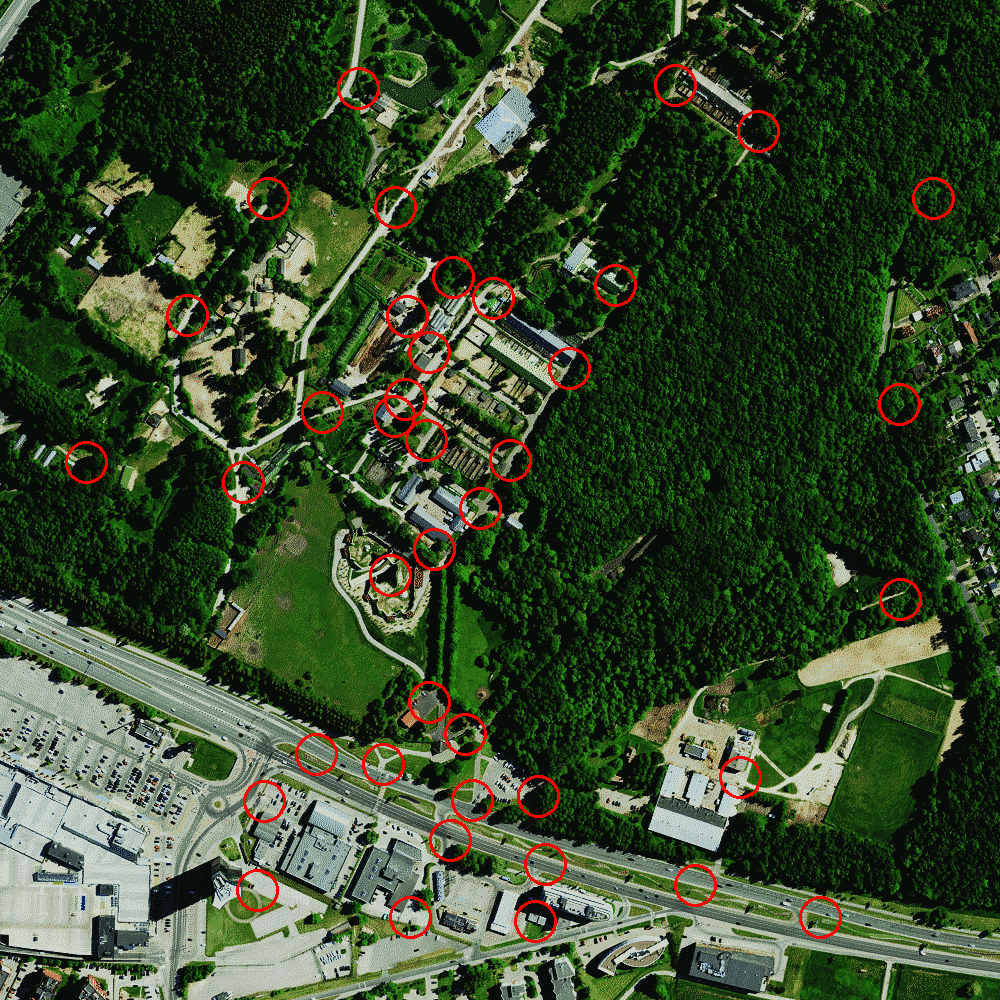

In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

def filter(intersections, max_count=100):

  if len(intersections) == 0:
    return 0, []

  # A list holds the SSE values for each k
  kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
  }

  sse = []
  cluster_centers = []

  for k in range(0, min(len(intersections), max_count)):
    kmeans = KMeans(n_clusters=k+1, **kmeans_kwargs)
    kmeans.fit(intersections)
    sse.append(kmeans.inertia_)
    cluster_centers.append(kmeans.cluster_centers_)

  k = np.sum(sse>=(np.mean(sse)-0.25*np.std(sse)))

  return k, cluster_centers[k-1], sse

k, clusters, sse = filter(intersections)
print("Selected k", k)

img = gif_orto.copy()
for (x, y) in clusters:
    cv2.circle(img, (int(x), int(y)), 20, (0, 0, 255), 2)

cv2_imshow(img)

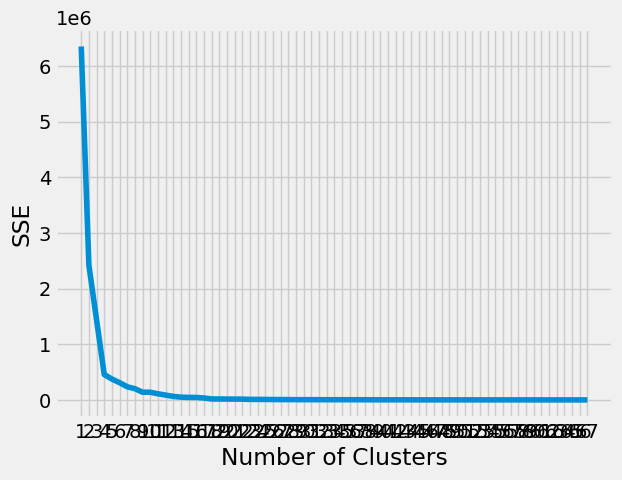

In [ ]:
plt.style.use("fivethirtyeight")
plt.plot(range(1, len(sse)+1), sse)
plt.xticks(range(1, len(sse)+1))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [ ]:
UPPER_LIMIT = 999

train_df = pd.read_csv(f'/content/train_centernet.csv')
train_df

image_id   xmin   ymin  width  height  centerx  centery
0      372000_6472000  907.0  643.0   30.0    30.0      922      658
1      372000_6472000  929.0  651.0   30.0    30.0      944      666
2      372000_6472000  970.0  748.0   29.0    30.0      985      763
3      372000_6472000  959.0  933.0   30.0    30.0      974      948
4      373000_6463000  310.0  943.0   30.0    30.0      325      958
...               ...    ...    ...    ...     ...      ...      ...
41539  725000_6577000  404.0  542.0   30.0    30.0      419      557
41540  725000_6577000  428.0  572.0   30.0    30.0      443      587
41541  725000_6577000  547.0  689.0   30.0    30.0      562      704
41542  725000_6577000  696.0  867.0   30.0    30.0      711      882
41543  725000_6577000  659.0  829.0   30.0    30.0      674      844

[41544 rows x 7 columns]

958/958 [==============================] - 4s 4ms/step


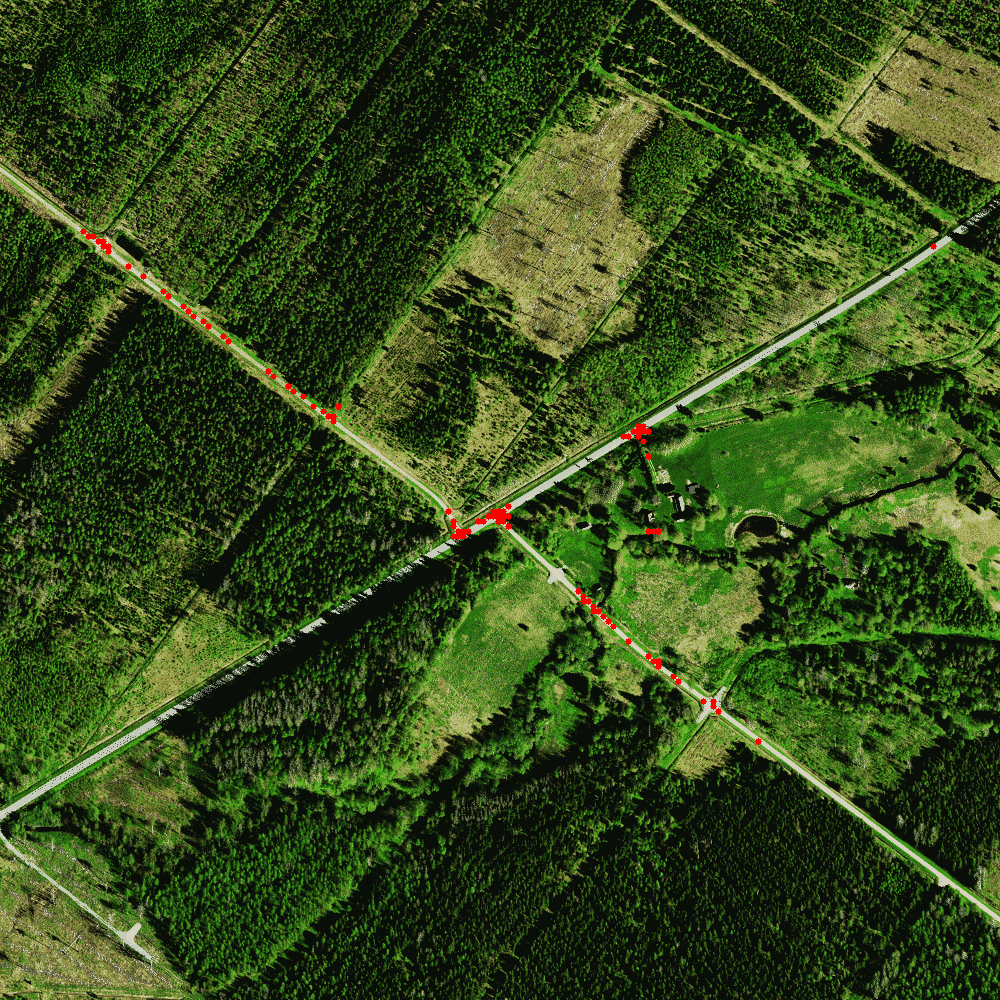

In [ ]:
from tensorflow.keras.models import load_model
import pandas as pd
import imageio
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

combined_model = load_model('/content/combined_model.keras')
df_test = pd.read_csv('/content/train_centernet.csv')
image_id = "667000_6567000"
gif_black = imageio.mimread(f"/content/P03_1000_test/test_black/black_{image_id}.gif")
gif_map = imageio.mimread(f"/content/P03_1000_test/test_map/map_{image_id}.gif")
gif_orto = imageio.mimread(f"/content/P03_1000_test/test_orto/orto_{image_id}.gif")

gif_black = np.flip(cv2.cvtColor(gif_black[0], cv2.COLOR_RGB2BGR), axis=0) #flip y axis because original y origin is below
gif_map = np.flip(cv2.cvtColor(gif_map[0], cv2.COLOR_RGB2BGR), axis=0) #flip y axis because original y origin is below
gif_orto = np.flip(cv2.cvtColor(gif_orto[0], cv2.COLOR_RGB2BGR), axis=0) #flip y axis because original y origin is below

cords = [(x, y) for y in range(size, 1000-size, 5) for x in range(size,1000-size,5)]

grid_black = np.zeros((len(cords),size,size,3), int)
grid_map = np.zeros((len(cords),size,size,3), int)
#grid_orto = np.zeros((len(cords),size,size,3), int)

index = 0

for x, y in cords:

  subimage_black = gif_black[y-size//2:y+size//2+1, x-size//2:x+size//2+1]
  subimage_map = gif_map[y-size//2:y+size//2+1, x-size//2:x+size//2+1]
  #subimage_orto = gif_orto[y-size//2:y+size//2+1, x-size//2:x+size//2+1]

  if subimage_black.shape[0] == size and subimage_black.shape[1] == size:
    grid_black[index] = subimage_black #np.concatenate((grid, [subimage]))
    grid_map[index] = subimage_map
    #grid_orto[index] = subimage_orto
    index += 1

prediction_map = combined_model.predict([grid_map, grid_black])

intersections = []
img = gif_orto.copy()
for (pred_0, pred_1), (x, y) in zip(prediction_map, cords):
  if pred_1>=0.99: #predict accept thrshold
      cv2.circle(img, (x, y), 3, (0, 0, 255), -1)
      intersections.append([x,y])


filtered_rows = df_test[df_test['image_id'] == image_id]

for index, row in filtered_rows.iterrows():

    xmin = int(row['xmin'])
    ymin = int(row['ymin'])
    width = int(row['width'])
    height = int(row['height'])

    cv2.rectangle(img, (xmin, ymin), (xmin + width, ymin + width), (0, 255, 0), 1)

img = cv2.flip(img, 0)

cv2_imshow(img)